In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Читаем файл с параметрами, в качестве индекса задаем дату.

In [5]:
df = pd.read_csv('water_df.csv').drop('date',axis=1)
#df.index = pd.to_datetime(df.index)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499400 entries, 0 to 499399
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sec_from_start  499400 non-null  int64  
 1   cond            499400 non-null  float64
 2   o2              499400 non-null  float64
 3   orp             499400 non-null  float64
 4   tds             499400 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 19.1 MB


None

,sec_from_start,cond,o2,orp,tds
0,600,359.0,62.9,474.0,369
1,601,353.0,62.9,473.9,369
2,602,345.0,62.7,473.9,370
3,603,342.0,62.8,474.0,370
4,604,339.0,62.8,474.1,368


,sec_from_start,cond,o2,orp,tds
sec_from_start,1.000000,-0.908677,0.445197,-0.417104,0.975490
cond,-0.908677,1.000000,-0.323032,0.489036,-0.898981
o2,0.445197,-0.323032,1.000000,0.282644,0.390842
orp,-0.417104,0.489036,0.282644,1.000000,-0.448095
tds,0.975490,-0.898981,0.390842,-0.448095,1.000000


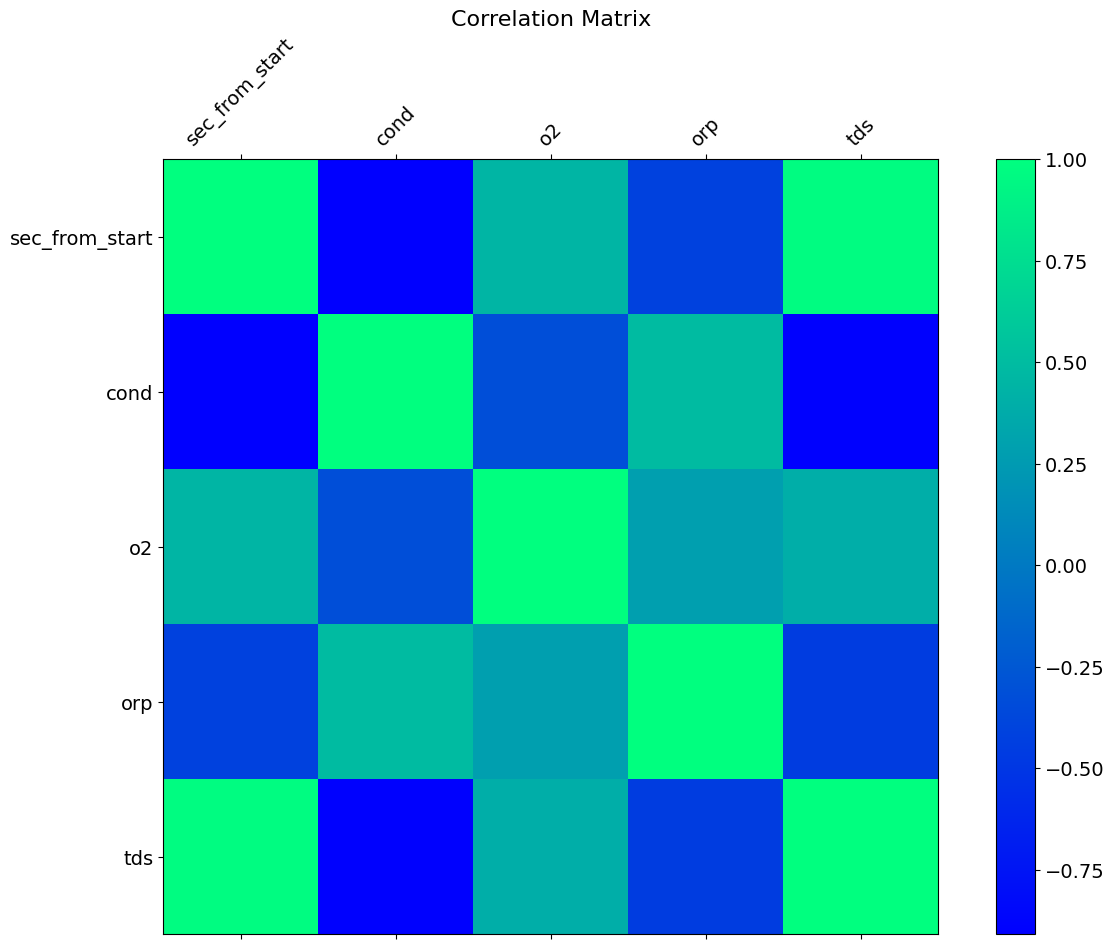

In [6]:
display(df.corr())

f = plt.figure(figsize=(15, 10))
plt.matshow(df.corr(), fignum=f.number, cmap='winter')
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

##### Из матрицы корреляций видно, что каждый параметр влияет на целевой cond, следовательно, имеет смысл обучать модель на всех признаках

In [13]:
x_train = df.drop('cond',axis=1)[:450000]
y_train = df['cond'][:450000]
x_test = df.drop('cond',axis=1)[450000:]
y_test = df['cond'][450000:]

display(x_train.head())
display(y_train.head())

print(x_train.shape)
print(x_test.shape)

,sec_from_start,o2,orp,tds
0,600,62.9,474.0,369
1,601,62.9,473.9,369
2,602,62.7,473.9,370
3,603,62.8,474.0,370
4,604,62.8,474.1,368


0    359.0
1    353.0
2    345.0
3    342.0
4    339.0
Name: cond, dtype: float64

(450000, 4)
(49400, 4)


## Подбираем наиболее ресурсоемкий параметр для GradientBoostingRegressor - n_estimators.
##### Этот параметр показывает, сколько деревьев решений задействовано в алгоритме. Чем их больше, тем выше шанс на переобучение и более долгое время тренировки.

In [6]:
%%time

parameters = {'n_estimators': list(range(20,200,2))}

clf = GridSearchCV(GradientBoostingRegressor(random_state=1), parameters, cv=5, verbose=5)# n_jobs=-1
clf.fit(x_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END ..................n_estimators=20;, score=-0.307 total time=   6.5s
[CV 2/5] END ..................n_estimators=20;, score=-0.061 total time=   6.5s
[CV 3/5] END ...................n_estimators=20;, score=0.143 total time=   6.3s
[CV 4/5] END ..................n_estimators=20;, score=-0.359 total time=   6.3s
[CV 5/5] END ..................n_estimators=20;, score=-0.066 total time=   6.2s
[CV 1/5] END ..................n_estimators=22;, score=-0.232 total time=   7.0s
[CV 2/5] END ..................n_estimators=22;, score=-0.103 total time=   7.1s
[CV 3/5] END ...................n_estimators=22;, score=0.151 total time=   7.0s
[CV 4/5] END ..................n_estimators=22;, score=-0.286 total time=   7.1s
[CV 5/5] END ..................n_estimators=22;, score=-0.020 total time=   6.8s
[CV 1/5] END ..................n_estimators=24;, score=-0.101 total time=   7.7s
[CV 2/5] END ..................n_estimators=24;

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             param_grid={'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34, 36,
                                          38, 40, 42, 44, 46, 48, 50, 52, 54,
                                          56, 58, 60, 62, 64, 66, 68, 70, 72,
                                          74, 76, 78, ...]},
             verbose=5)

In [21]:
print(clf.score(x_train, y_train))
print(clf.best_params_)

0.8828698003069135
{'n_estimators': 32}


##### За 4.5 часа, алгоритм подобрал оптимальное значение параметра n_estimators = 32. Так как тесты начинались с n_estimators = 30, повторим эксперимент, начиная подбор с  n_estimators = 1

In [19]:
%%time

parameters = {'n_estimators': np.linspace(1, 32, 32).astype(int)}

clf = GridSearchCV(GradientBoostingRegressor(random_state=1), parameters, cv=5, verbose=5)# n_jobs=-1
clf.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ...................n_estimators=1;, score=-4.079 total time=   0.2s
[CV 2/5] END ...................n_estimators=1;, score=-3.193 total time=   0.2s
[CV 3/5] END ...................n_estimators=1;, score=-0.162 total time=   0.2s
[CV 4/5] END ...................n_estimators=1;, score=-3.428 total time=   0.2s
[CV 5/5] END ..................n_estimators=1;, score=-12.600 total time=   0.2s
[CV 1/5] END ...................n_estimators=2;, score=-3.382 total time=   0.6s
[CV 2/5] END ...................n_estimators=2;, score=-2.688 total time=   0.5s
[CV 3/5] END ...................n_estimators=2;, score=-0.073 total time=   0.5s
[CV 4/5] END ...................n_estimators=2;, score=-2.342 total time=   0.5s
[CV 5/5] END ..................n_estimators=2;, score=-11.043 total time=   0.5s
[CV 1/5] END ...................n_estimators=3;, score=-2.987 total time=   0.8s
[CV 2/5] END ...................n_estimators=3;

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])},
             verbose=5)

In [23]:
print(clf.score(x_train, y_train))
print(clf.best_params_)
display(pd.DataFrame(clf.cv_results_))

0.8828698003069135
{'n_estimators': 32}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.325318,0.007229,0.007261,0.007075,1,{'n_estimators': 1},-4.078675,-3.193358,-0.161788,-3.428077,-12.599859,-4.692351,4.177958,32
1,0.606993,0.032044,0.006388,0.005090,2,{'n_estimators': 2},-3.381642,-2.688058,-0.072834,-2.342495,-11.042942,-3.905594,3.737164,31
2,0.881842,0.013347,0.004357,0.006121,3,{'n_estimators': 3},-2.986543,-2.332878,0.093226,-1.549410,-9.581794,-3.271480,3.318704,30
3,1.192555,0.014556,0.001233,0.002466,4,{'n_estimators': 4},-2.617935,-1.748612,0.127546,-1.309834,-8.476353,-2.805038,2.971550,29
4,1.474616,0.028260,0.008697,0.006086,5,{'n_estimators': 5},-2.194192,-1.281798,0.229476,-0.954287,-7.425299,-2.325220,2.665432,28
5,1.778044,0.042397,0.007183,0.004981,6,{'n_estimators': 6},-1.957449,-1.076232,0.278833,-0.556763,-6.488458,-1.960014,2.377790,27
6,2.061740,0.020074,0.006704,0.002037,7,{'n_estimators': 7},-1.741940,-0.792737,0.326297,-0.451726,-5.738859,-1.679793,2.135382,26
7,2.362298,0.048285,0.006542,0.001097,8,{'n_estimators': 8},-1.487245,-0.664492,0.325670,-0.248575,-5.066242,-1.428177,1.912572,25
8,2.587288,0.026481,0.008123,0.000143,9,{'n_estimators': 9},-1.332717,-0.573905,0.325920,-0.118007,-4.564480,-1.252638,1.744398,24
9,2.873112,0.017263,0.006968,0.004276,10,{'n_estimators': 10},-1.196264,-0.461192,0.327983,-0.008918,-4.098872,-1.087452,1.589930,23


##### Коэффициент детерминации r2 получился 0.882 на тренировочной выборке

## Подбираем остальные гиперпараметры GradientBoostingRegressor с n_estimators = 32

In [26]:
%%time

parameters = {'n_estimators': [32],
              'min_samples_split':[2,3,4,5,6],
              'min_samples_leaf': np.linspace(1, 10, 10).astype(int),
              'max_depth':[3,4,5,6]}

clf = GridSearchCV(GradientBoostingRegressor(random_state=1), parameters, cv=5, verbose=5)# n_jobs=-1
clf.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=32;, score=-0.236 total time=   9.2s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=32;, score=0.051 total time=   9.4s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=32;, score=0.315 total time=   9.2s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=32;, score=0.336 total time=   9.0s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=32;, score=-1.354 total time=   9.0s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=32;, score=-0.236 total time=   9.2s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=32;, score=0.051 total time=   9.2s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=32;, score=0.315 total time=   9.1s
[CV 4

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [32]},
             verbose=5)

In [ ]:
print(clf.score(x_train, y_train))
print(clf.best_params_)
display(pd.DataFrame(clf.cv_results_))